# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 01/11/2022

In [ ]:
#Import necessary packages

import pandas as pd #to work with data arrays
!pip uninstall statsmodels
!pip install statsmodels
!pip install geopandas
import geopandas as gpd #to work with spatial data
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels import tsa
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.distributions import empirical_distribution
import seaborn as sns
import scipy
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

Found existing installation: statsmodels 0.10.2
Uninstalling statsmodels-0.10.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.10.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 9.8 MB 17.9 MB/s 
     |████████████████████████████████| 1.0 MB 27.4 MB/s 
     |████████████████████████████████| 15.4 MB 45.5 MB/s 
     |████████████████████████████████| 6.3 MB 56.4 MB/s 
     |████████████████████████████████| 1.4 MB 20.0 MB/s 


In [ ]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [ ]:
#Import data files
#Can comment after first run 

# div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
# full_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63_WRA_all.csv', parse_dates=['DataDate'], index_col=['DataDate'])
# print(div_wd63.dtypes)
# print(full_wd63.dtypes)

In [ ]:
## RENAME THE COLUMNS TO MATCH OLD TIMESERIES DESCRIPTIONS
## Can comment out after first run

# full_wd63 = full_wd63.rename(columns={'SiteID':'HydrologyID', 'FullName':'DiversionName',
#                                       'Description':'DiversionTypeDescription', 'DataDate':'DiversionDate'})

# ## replace SURPRISE VALLEY/MICRON with surprise_vy_micron to export CSV

# full_wd63['DiversionName'] = full_wd63['DiversionName'].replace(to_replace='SURPRISE VALLEY/MICRON',
#                                                                 value='SURPRISE_VALLEY_MICRON')

In [ ]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

# div_name = np.unique(full_wd63['DiversionName']) #get unique identifier for each div point
# print(div_name)

# for n in div_name:
#   canal = full_wd63[full_wd63['DiversionName']== n] #creates a dataframe for each canal name
#   canal = canal.sort_index() #sorts data by date
#   file_name = 'datasets/diversion_timeseries/fulltime_individual_canals/'+ str(n) +'.csv' #creates a file path
#   canal.to_csv(file_name) #exports csv to directory

In [ ]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###

all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/fulltime_individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DataDate'], index_col=['DataDate'])
  all_files.append(df) #appends dataframes to one file list

In [ ]:
#Plot the data to see the timescale

###----------------------------------###
### CREATES ONE FIGURE FOR ALL PLOTS ###
###----------------------------------###

len(all_files)
i,j = 0,0
plot_row = 4 #number of plots per row in figure
figure, ax = plt.subplots(33, plot_row, figsize=(30,150)) #create the figure
file_len = np.array(np.arange(0,len(all_files),1)) #total count of files

for f in file_len: #run a for loop to add all plots to figure
  canal_data = all_files[f] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'], 'o')
  ax[i][j].set_ylabel('Discharge (cfs)')
  ax[i][j].set_xlabel('Time')
  ax[i][j].title.set_text(canal_data['DiversionName'].iloc[0])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

###---------------------------------------------###
### CREATES INDIVIDUAL PLOTS FOR EACH DIVERSION ###
###---------------------------------------------###

for f in file_len:
  canal_data = all_files[f]
  fig = plt.figure(figsize= (9,7))
  ax = fig.add_subplot(1,1,1)
  ax.plot(canal_data.index, canal_data['CFS'], 'o')
  ax.set_ylabel('Discharge (cfs)')
  ax.set_xlabel('Time')
  ax.title.set_text(canal_data['DiversionName'].iloc[0])
  file_path = ('datasets/diversion_timeseries/individualplots/'+ canal_data['DiversionName'].iloc[0] +'.png')
  plt.savefig(file_path) #exports the file 


In [ ]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Select only the diversions known to serve irrigation districts
#  Will remove reservoir, natural flow, and return flow data

diversion_list = [] #create a list to store the diversion data frame in

for i in range(len(all_files)):
  sel_data = all_files[i]
  data_type = sel_data['DiversionTypeDescription'][1]
  if data_type == ('Diversion' or 'Non-consumptive' or 'Combined Use'):
    diversion_list.append(sel_data)
  else:
    None

## Select diversions with data from 1987-2021 for study
## All else is discarded

fullextent_list = []

for i in range(len(diversion_list)):
  sel_data = diversion_list[i]
  oldest_year = sel_data.index.year[0]
  if oldest_year <= 1987:
    fullextent_list.append(sel_data)
  else:
    None

## Crop each time series with full extent range to desired time series

croppped_data = []

for i in fullextent_list:
  sel_data = i
  if sel_data.index.year[-1]>=1987:
    crop = sel_data.truncate(before='1987-01-01')
    croppped_data.append(crop)
  else:
    None

## Find the names of all the canals in the dataframe list

names = []

for i in croppped_data:
  canal = i['DiversionName']
  names.append(canal[0])

## Fill in any missing winter values with 0 starting at 1987-01-01

dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canalss = []

for i in range(len(croppped_data)):
  canal = croppped_data[i] #selects the specific diversion dataframe
  canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
  canal = canal.drop(labels=0, axis=1) #dropes the series column
  canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
  canal = canal.asfreq('d') #fill each daily value
  canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
  canal['DiversionName'] = canal['DiversionName'].fillna(names[i]) #fills Nan diversion name values
  canalss.append(canal)

## Remove pioneer dixie from original analysis until figuring out how to manage it

canals_nopd = []

for i in range(len(canalss)):
  canal = canalss[i]
  if canal['DiversionName'].iloc[0] != 'PIONEER DIXIE':
    canals_nopd.append(canal)
  else: 
    None

## Remove diversions from upper boise river basin
## Only one present: USFS LUCKY PEAK NURSERY

canals = []

for i in range(len(canals_nopd)):
  canal = canals_nopd[i]
  if canal['DiversionName'].iloc[0] != 'USFS LUCKY PEAK NURSERY':
    canals.append(canal)
  else: 
    None

In [ ]:
## IMPORT RESERVOIR FILL FILE TO NORMALIZE DIVERTED VOLUME TO AVAILABLE WATER ##
## -------------------------------------------------------------------------- ##
## Try two metrics: 
##       1) Max reservoir fill
##       2) Fill at the earliest start of the irrigation season
## -------------------------------------------------------------------------- ##

fill = pd.read_csv('datasets/diversion_timeseries/reservoir_fill.csv', parse_dates=['DateTime'], index_col=['DateTime'])

## Find the max fill every year

max_fill = []
years = np.array(np.arange(1987,2021,1)) #creates an array for the years

for i in range(len(years)):
  data = fill[fill.index.year == years[i]]
  max_fill.append([years[i], np.max(data['total_storage'])])

max_fill = pd.DataFrame(max_fill, columns = ['Year', 'MaxFill'])





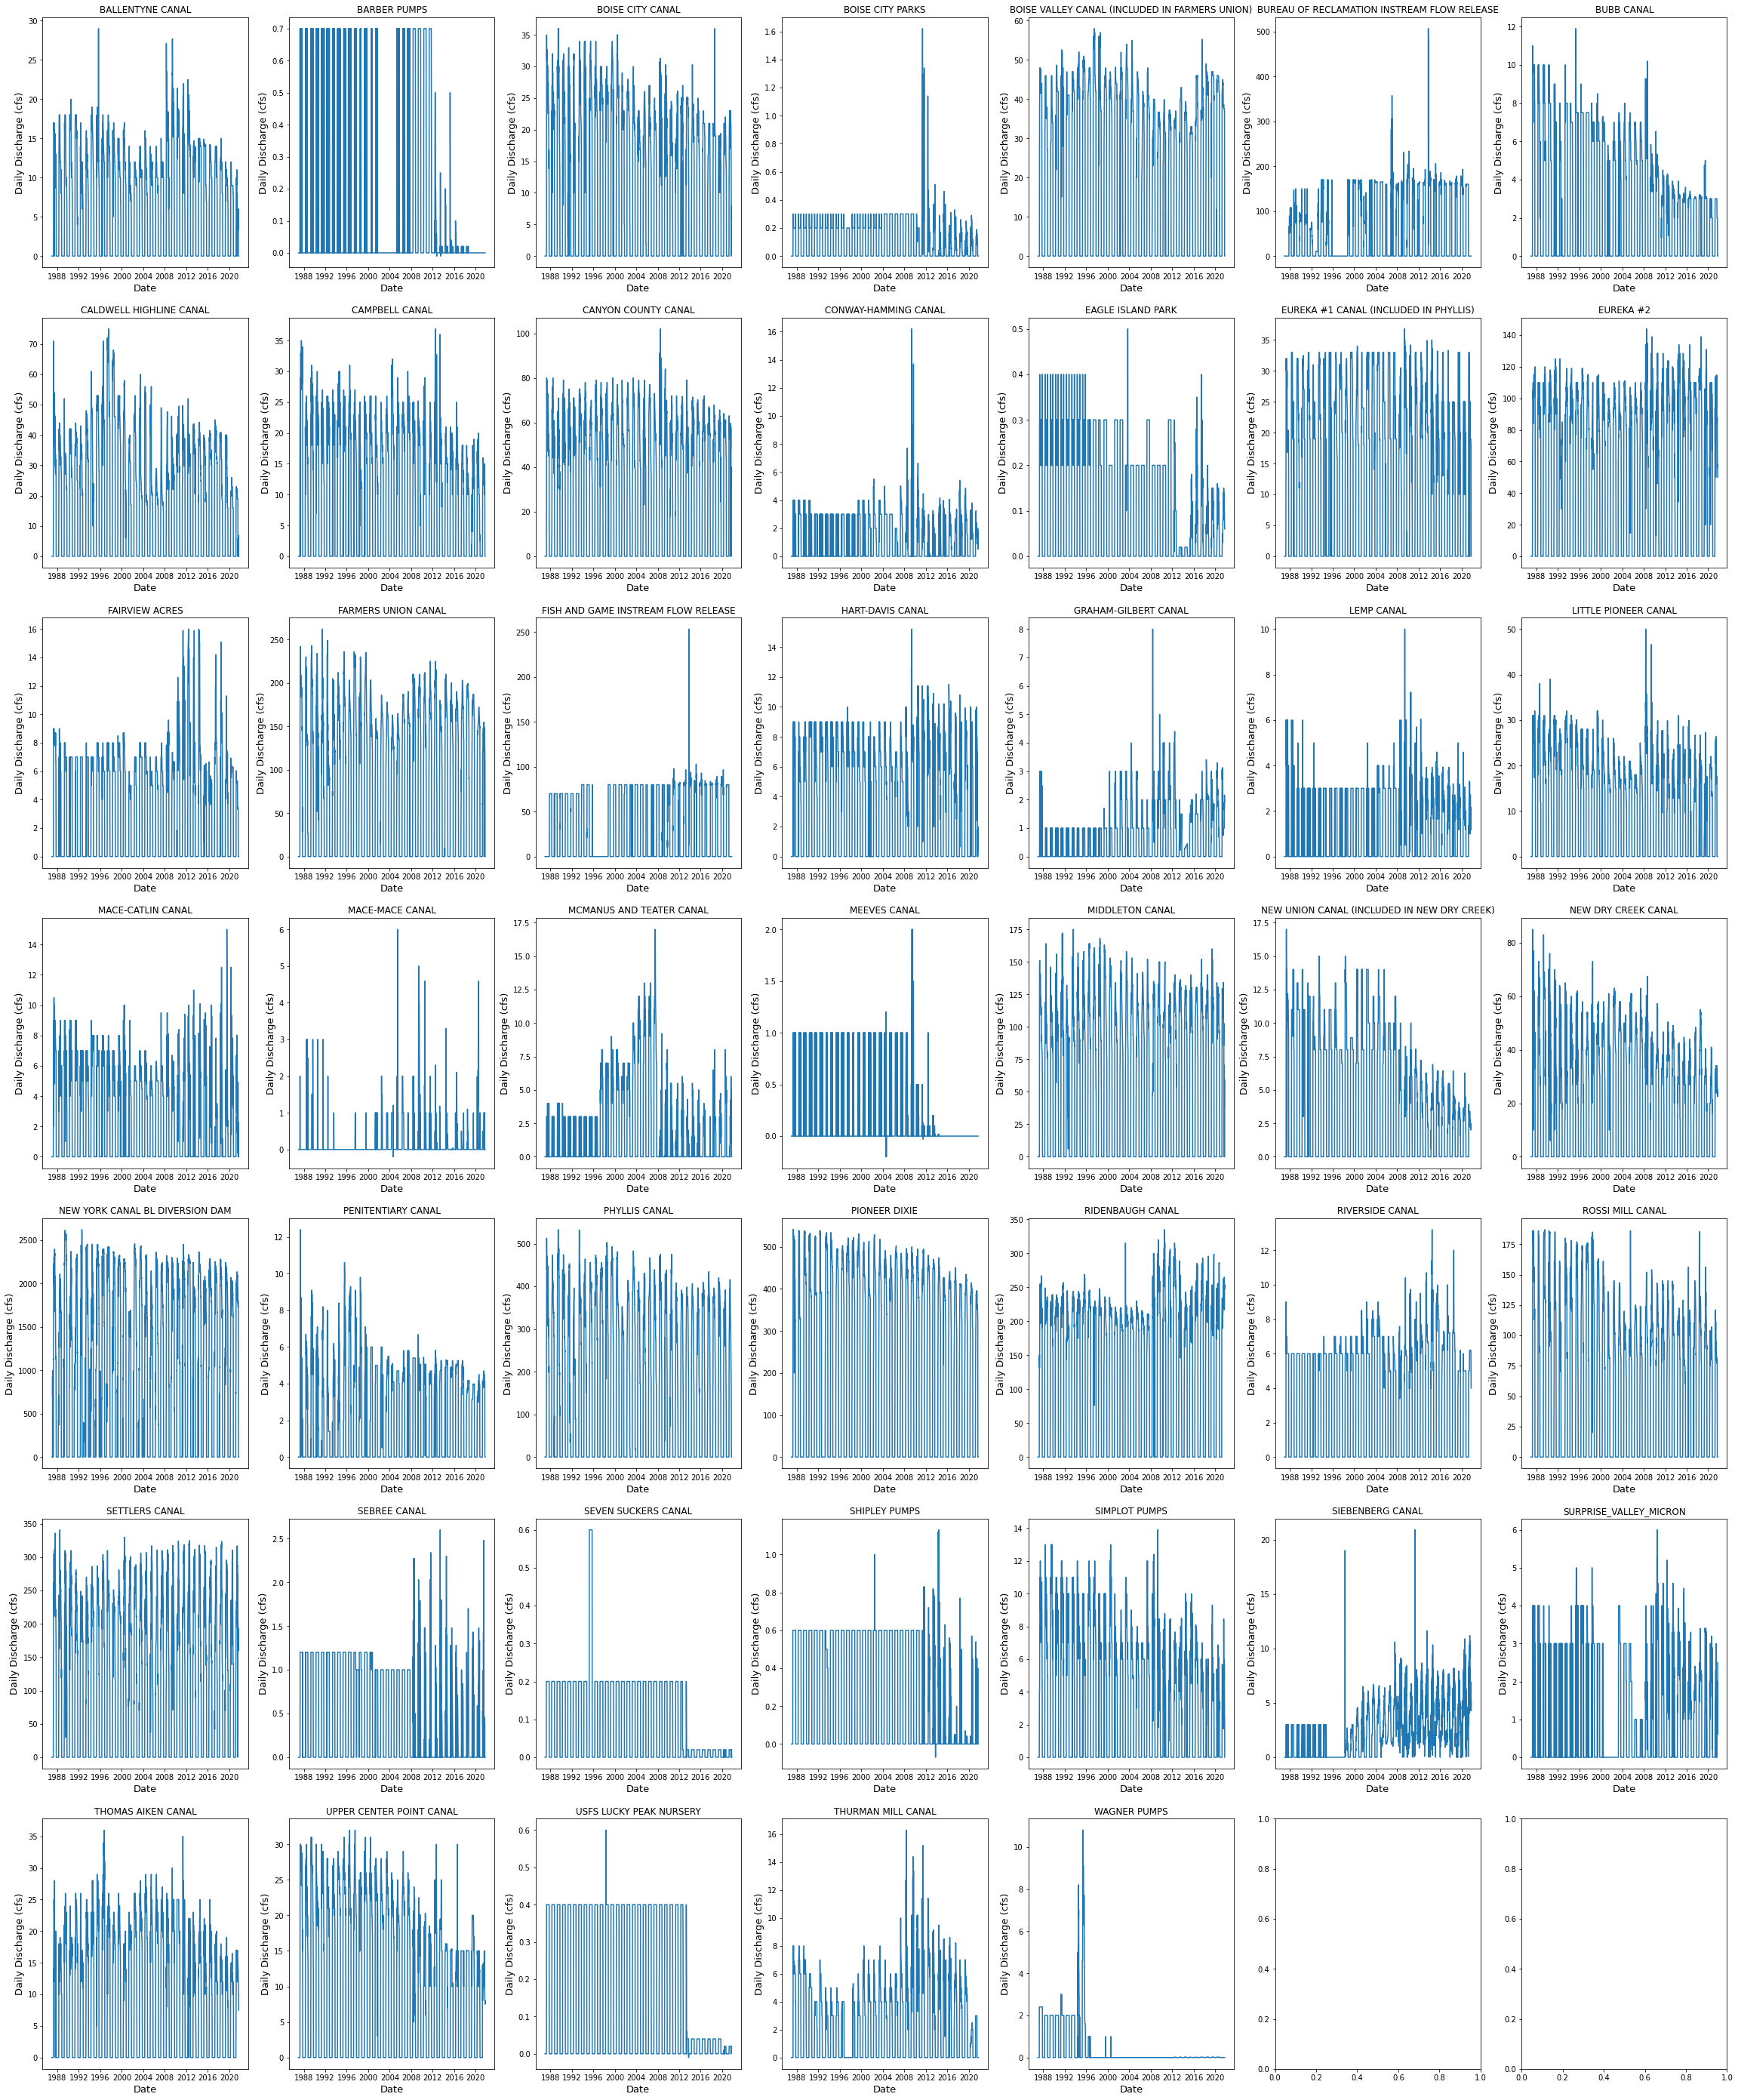

In [ ]:
## PLOT THE RAW DATA TO VISUALLY ANALYZE TRENDS AND SEASONALITY

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(7, plot_row, figsize=(40,50)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = canals[n] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'])
  ax[i][j].set_ylabel('Daily Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Date', size=13)
  ax[i][j].title.set_text(names[n])
  # ax[i][j].set_xticks(years)
  # ax[i][j].set_xticklabels(years, rotation=45)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/rawdata.png')


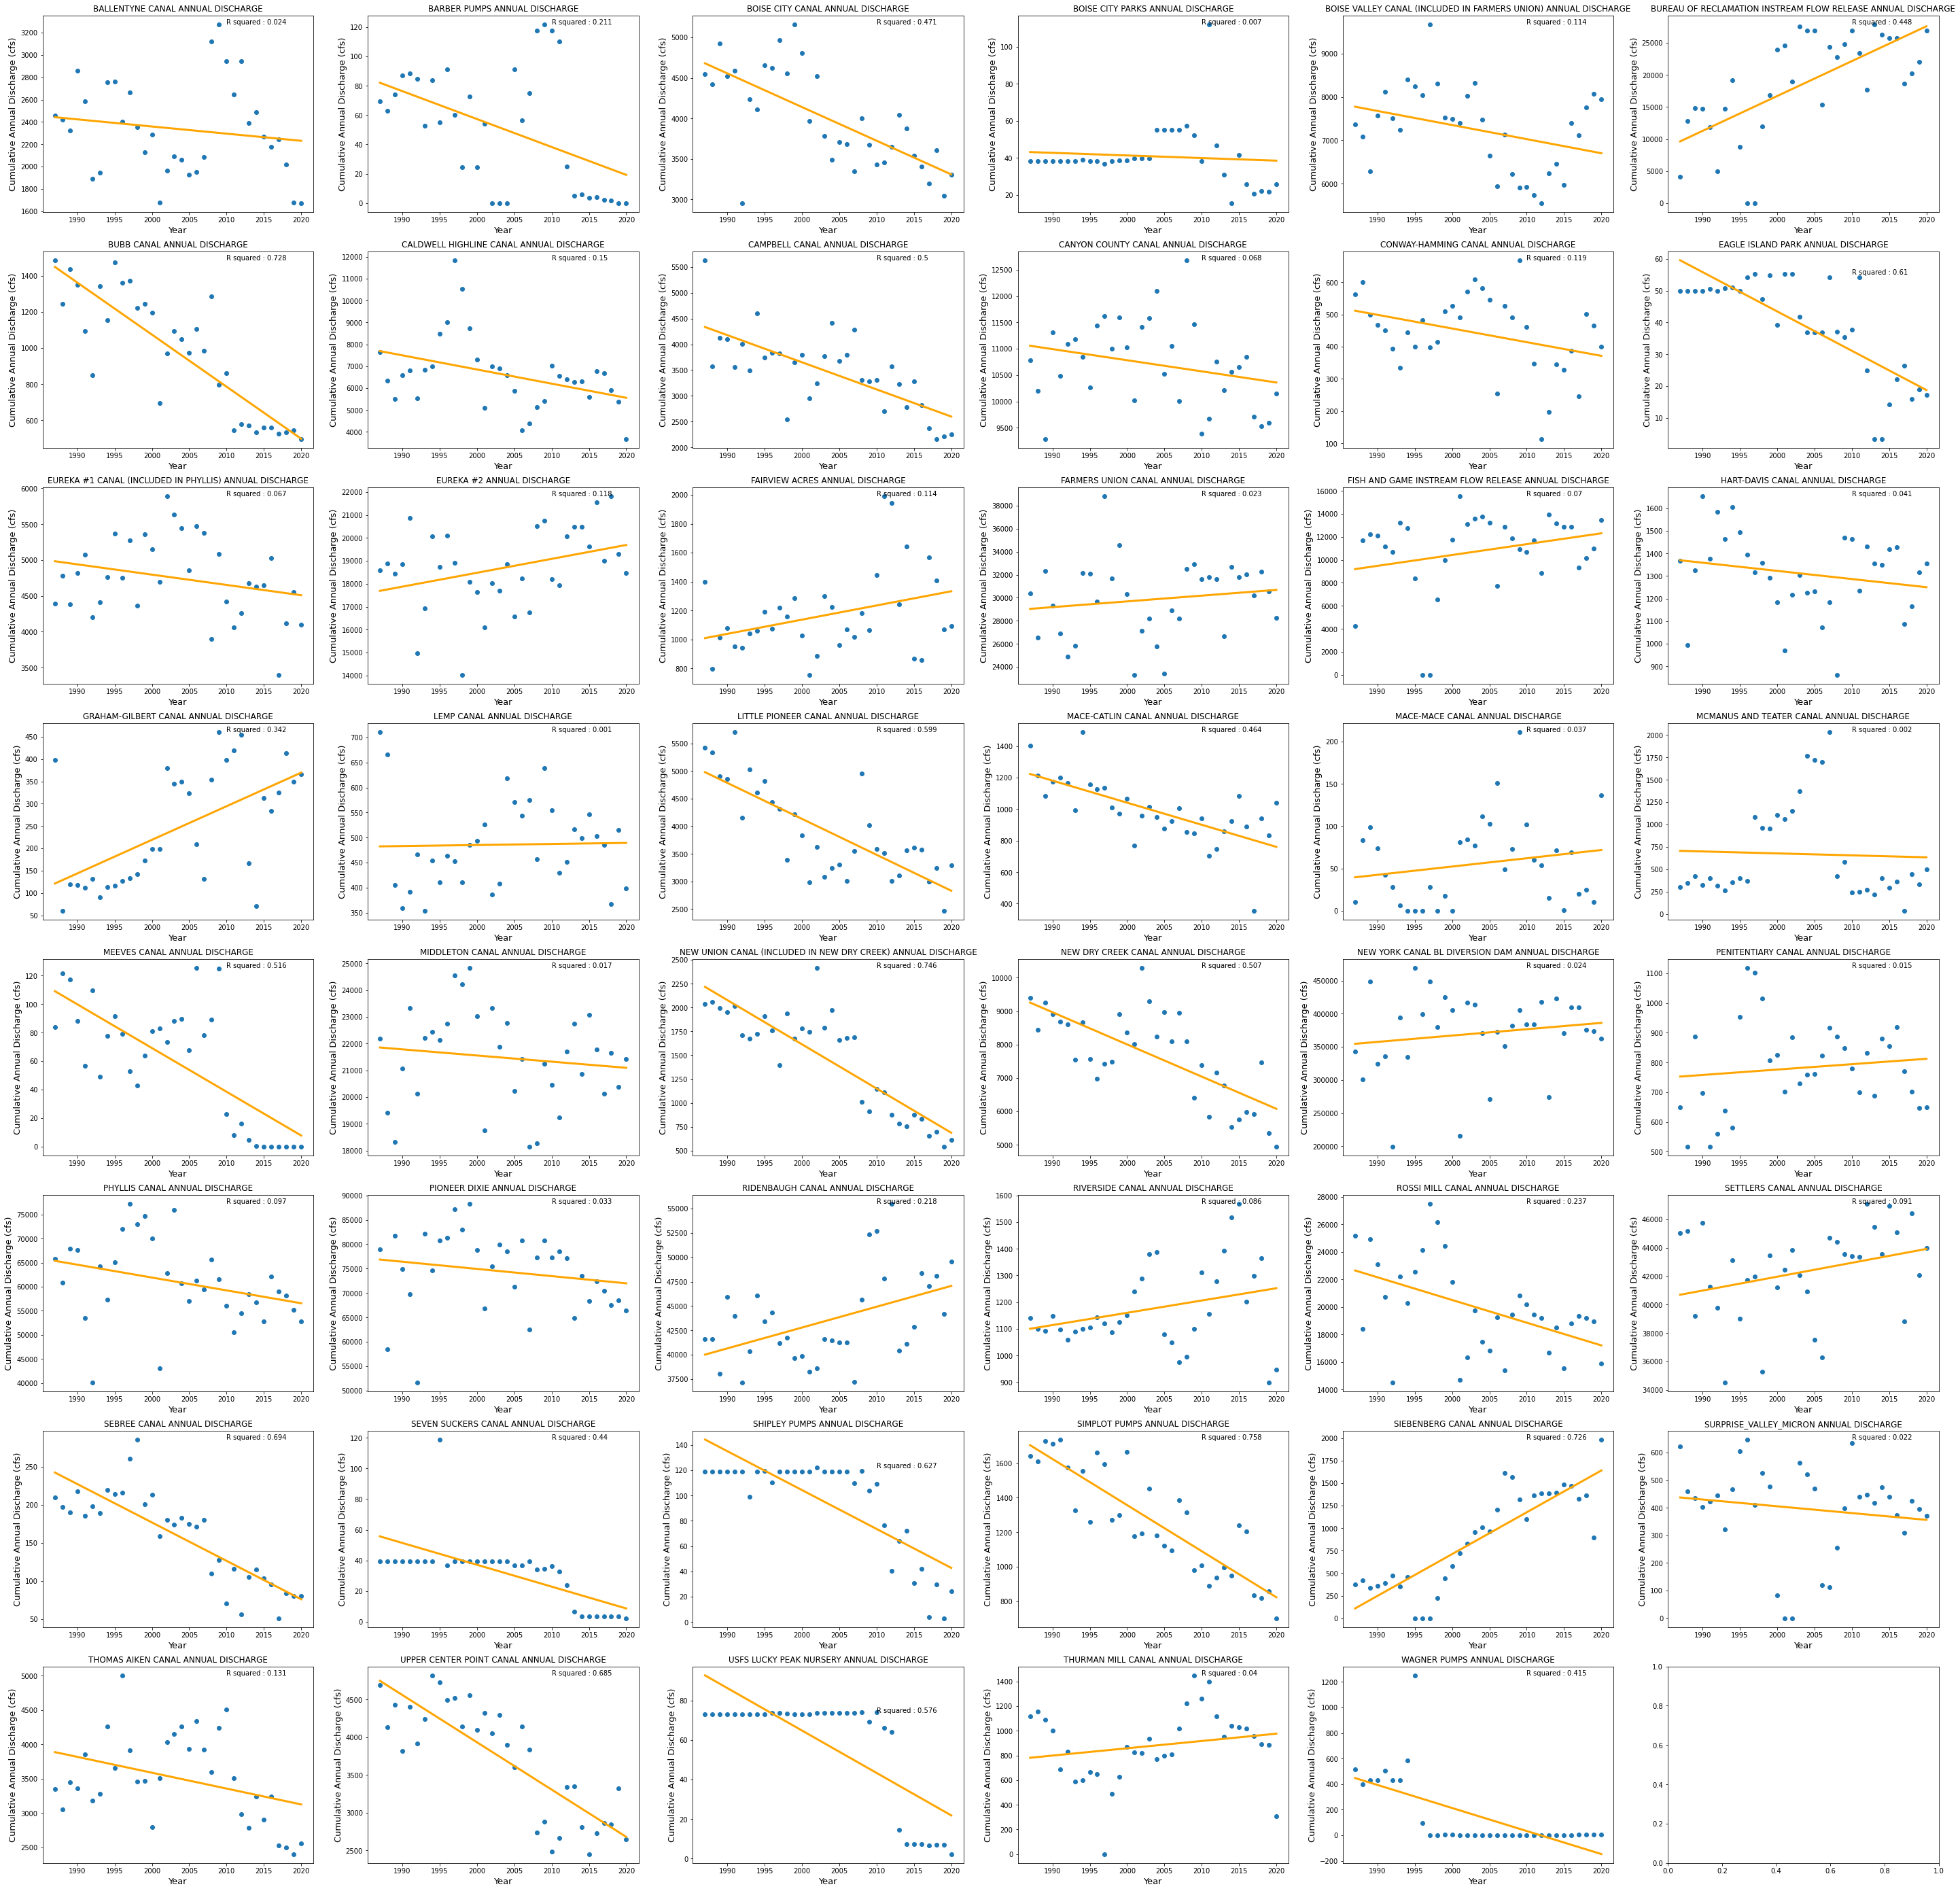

In [ ]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

totals = np.empty((len(years), len(canals)))
totals_df = []

for i in range(len(canals)):
  tot_list = []
  for y in range(len(years)):
    sub_canal = canals[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['CFS']) #sum the total discharge throughout the year
    tot_list.append([years[y], sub_canal['DiversionName'][0], sum(subset_year['CFS'])])
  tot_todf = pd.DataFrame(tot_list, columns = ['Year', 'Diversion Name', 'Total'])
  totals_df.append(tot_todf)

## CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(totals[:,i], regression[:,i]) #compares correlation of model to true values


## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 6 #number of plots per row in figure
figure, ax = plt.subplots(8, plot_row, figsize=(50,50)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

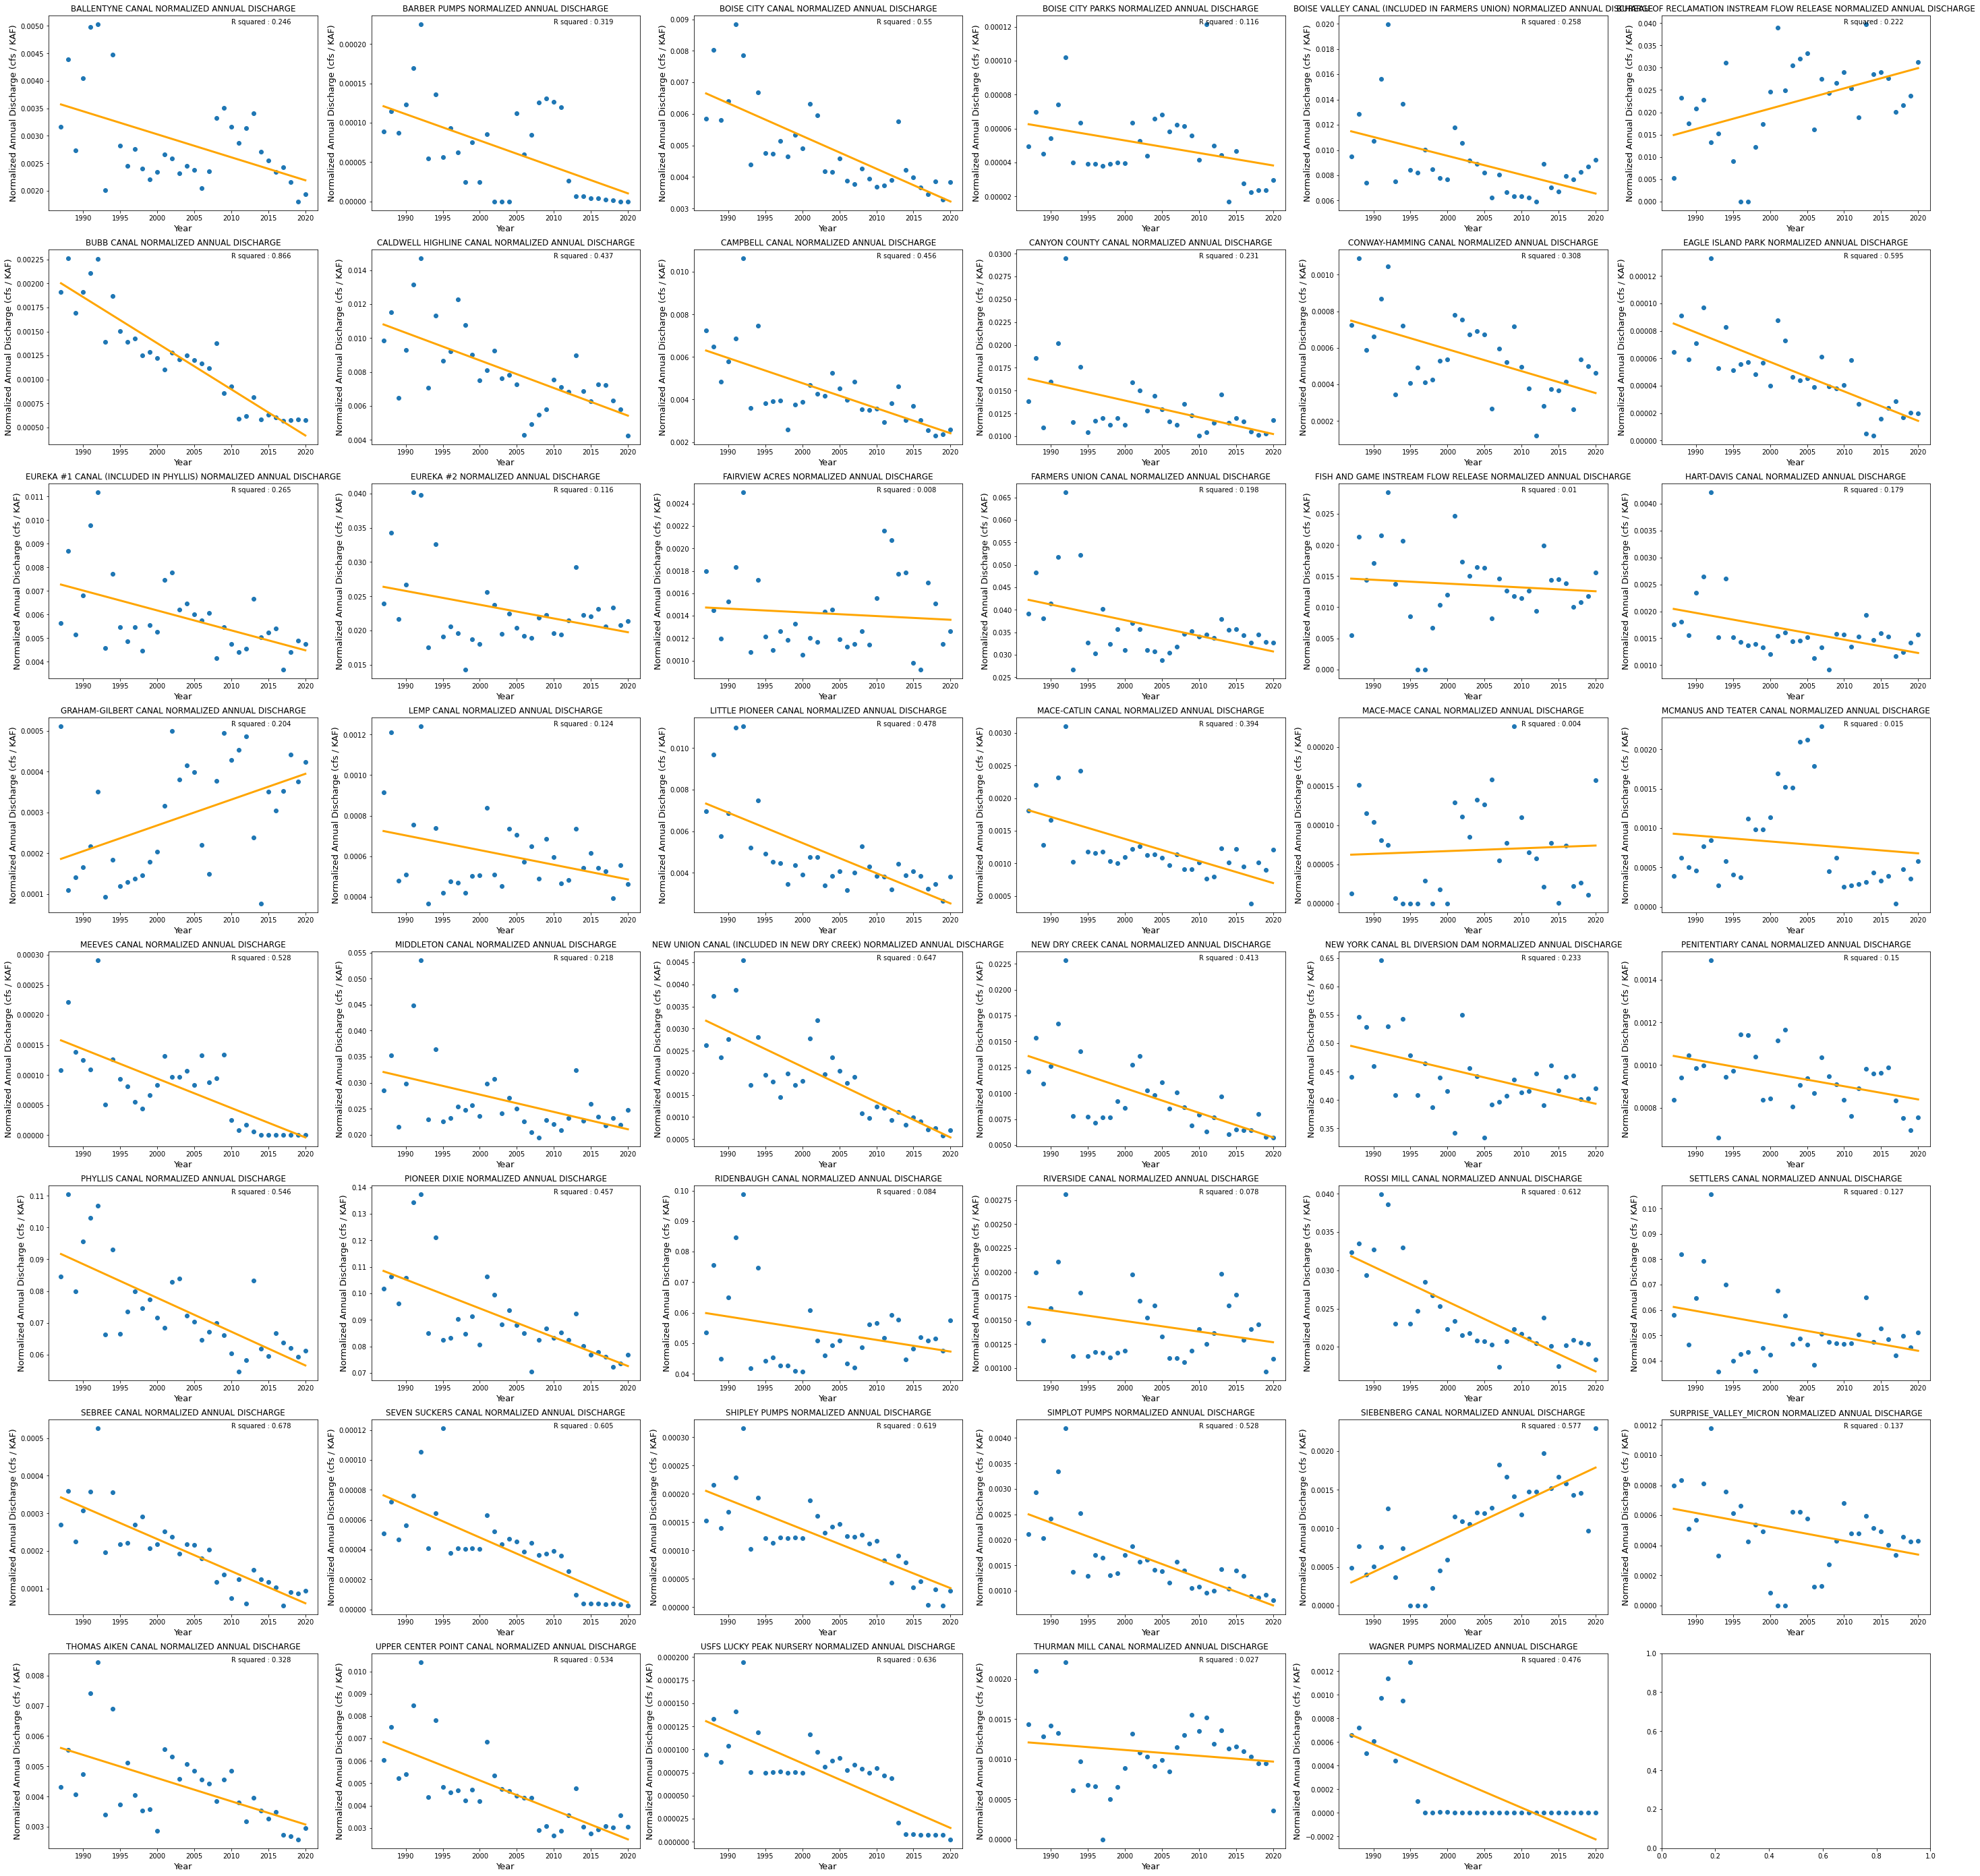

In [ ]:
## Normalize total water diverted to the max fill available that year

norm_totals = np.empty((len(years), len(canals)))

for y in range(len(years)):
  for i in range(len(canals)):
    cum_discharge = totals[y][i]
    res_fill = max_fill['MaxFill'][max_fill['Year'] == years[y]]
    norm_totals[y][i] = cum_discharge/res_fill

# CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, norm_totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(norm_totals[:,i], regression[:,i]) #compares correlation of model to true values

## Plot the normalized discharges

i,j = 0,0
plot_row = 6 #number of plots per row in figure
figure, ax = plt.subplots(8, plot_row, figsize=(50, 50)) #create the figure
for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = norm_totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Normalized Annual Discharge (cfs / KAF)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' NORMALIZED ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(norm_totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/norm_totals.png')


In [ ]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(canals)):
  canal = canals[i]
  avg = np.mean(canal['CFS'][canal['CFS'] != 0])
  std_dev = np.std(canal['CFS'][canal['CFS'] != 0])
  avg_withzero = np.mean(canal['CFS'])
  std_withzero = np.std(canal['CFS'])
  coeff_var = std_dev/avg
  coeff_var_withzero = std_withzero/avg_withzero
  maximum = np.max(canal['CFS'])
  minimum = np.min(canal['CFS'][canal['CFS'] != 0])
  stats.append([canal['DiversionName'][0], avg, std_dev, coeff_var, maximum, minimum, avg_withzero, std_withzero, coeff_var_withzero])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Mean', 'Standard_dev', 
                                            'Coefficient_Variation', 'Maximum', 'Minimum', 
                                            'Mean_ZeroValues', 'Standard_dev_ZeroValues',
                                            'Coefficient_ZeroValues'])


display(base_stats)
base_stats.to_csv('datasets/diversion_timeseries/figures/stats.csv')



,DiversionName,Mean,Standard_dev,Coefficient_Variation,Maximum,Minimum,Mean_ZeroValues,Standard_dev_ZeroValues,Coefficient_ZeroValues
0,BALLENTYNE CANAL,12.359398,3.945858,0.319260,29.00,0.20,6.333912,6.792942,1.072472
1,BARBER PUMPS,0.519222,0.291330,0.561090,0.70,-0.01,0.135538,0.272322,2.009190
2,BOISE CITY CANAL,21.923401,5.764135,0.262922,36.00,1.00,10.934950,11.693171,1.069339
3,BOISE CITY PARKS,0.227517,0.125479,0.551517,1.62,0.01,0.110490,0.143445,1.298271
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),39.404435,8.924988,0.226497,58.00,0.70,19.917805,20.697691,1.039155
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,132.629350,48.411075,0.365010,506.70,0.30,50.940612,71.143675,1.396600
6,BUBB CANAL,5.433314,2.270748,0.417931,11.90,0.20,2.642020,3.143560,1.189832
7,CALDWELL HIGHLINE CANAL,35.197561,12.487802,0.354792,75.00,2.25,17.957600,19.726903,1.098527
8,CAMPBELL CANAL,18.366154,6.101439,0.332211,36.90,0.29,9.436817,10.168216,1.077505
9,CANYON COUNTY CANAL,55.973146,14.068587,0.251345,102.00,0.70,29.394384,29.752429,1.012181


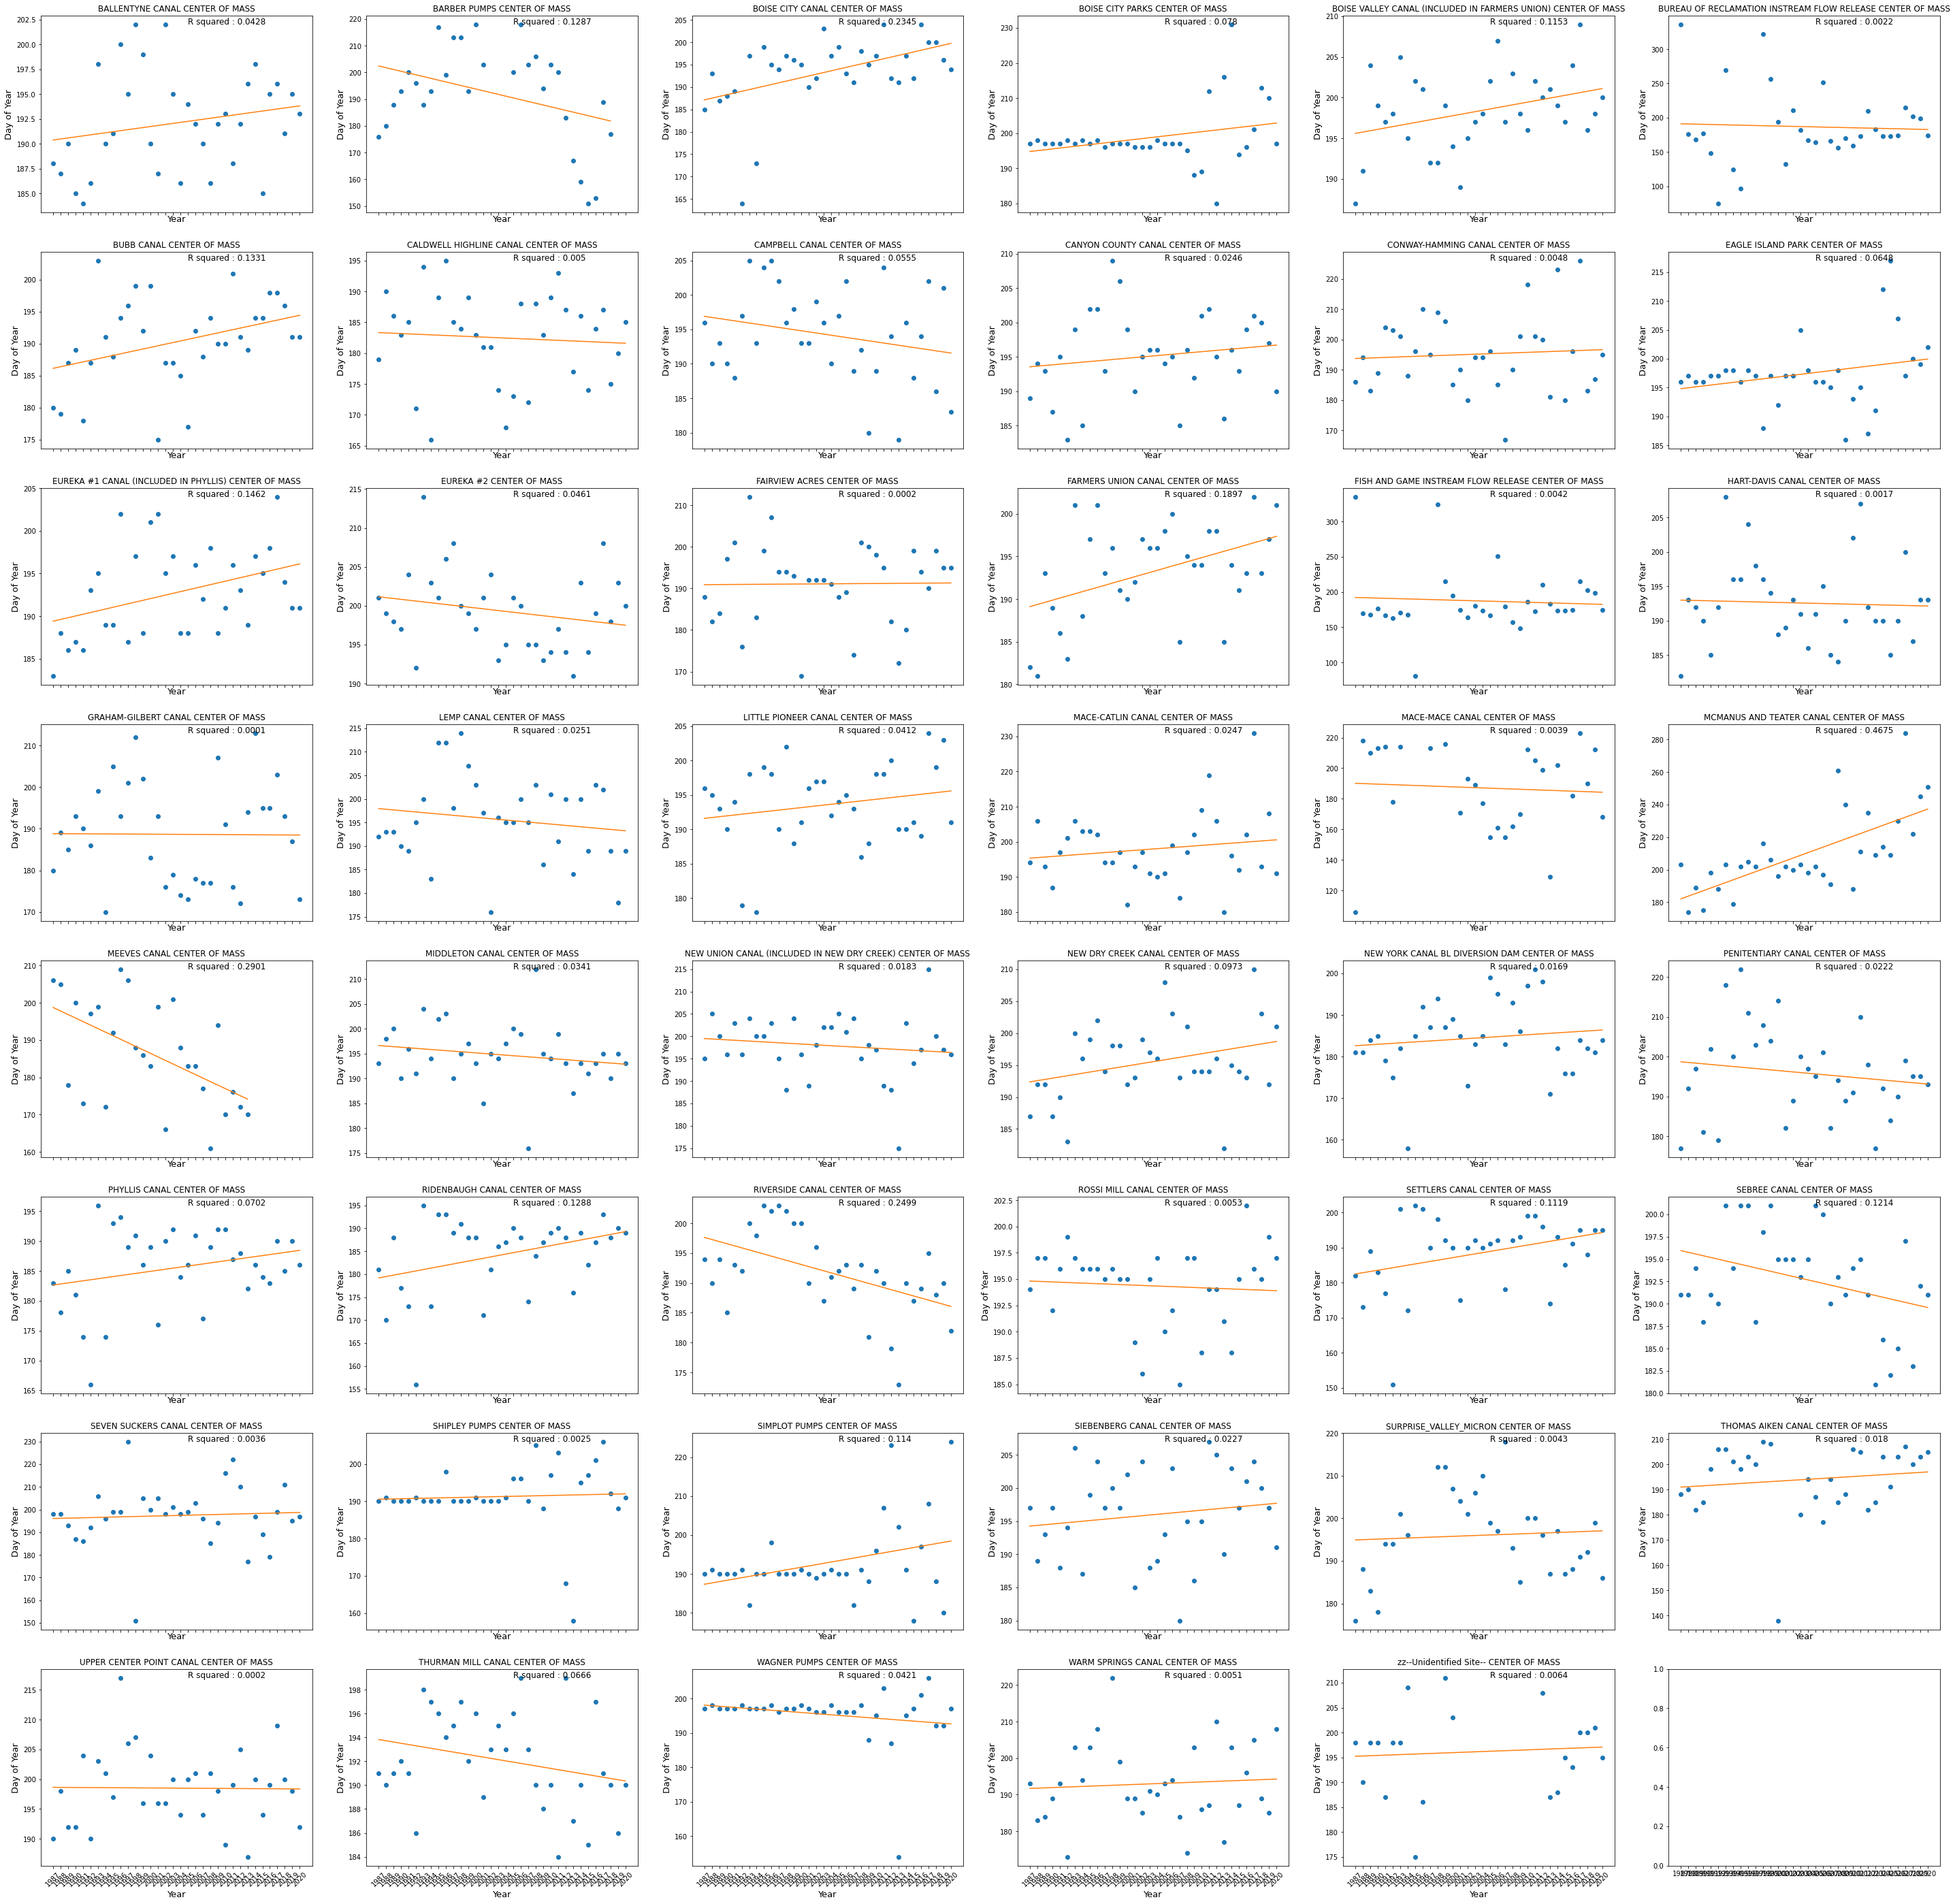

In [ ]:
## FIND THE CENTER OF MASS OF THE IRRIGATION SEASON ##

centroid_df = []

for n in range(len(canals)):
  cent_list = []
  for i in range(len(years)):
    canal = canals[n]
    tots = totals_df[n]
    year = canal[canal.index.year == years[i]]
    tot_year = int(tots['Total'][tots['Year'] == years[i]])
    if tot_year == 0:
      None
    else:
      cent = round(np.sum(year.index.dayofyear*year['CFS'])/np.sum(year['CFS']))
      cent_list.append([years[i], canal['DiversionName'][0], cent])
  cent_todf = pd.DataFrame(cent_list, columns = ['Year', 'DiversionName', 'CentroidDay'])
  centroid_df.append(cent_todf)

## Check to see if there is a trend in the data through time

r_squared_df = []

for i in range(len(canals)):
  canal = centroid_df[i]
  model = np.polyfit(canal['Year'], canal['CentroidDay'], deg=1)
  canal['Model'] = np.polyval(model, canal['Year'])
  centroid_df[i] = canal
  r_squared = metrics.r2_score(canal['CentroidDay'], canal['Model'])
  r_squared_df.append([canal['DiversionName'][0], r_squared])

r_squared_df = pd.DataFrame(r_squared_df, columns =['DiversionName', 'RSquared'])

## PLOT THE DAY AT CENTER OF MASS FOR EACH CANAL ##

i,j = 0,0
plot_row = 6 #number of plots per row in figure
figure, ax = plt.subplots(8, plot_row, figsize=(50,50), sharex=True) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = centroid_df[n] #takes an individual diversion point dataframe
  r_squared = r_squared_df['RSquared'][n]
  ax[i][j].plot(canal_data['Year'], canal_data['CentroidDay'], 'o')
  ax[i][j].plot(canal_data['Year'], canal_data['Model'])
  ax[i][j].set_ylabel('Day of Year', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal_data['DiversionName'][0] +' CENTER OF MASS')
  ax[i][j].tick_params('both')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  ax[i][j].text(2005, np.max(canal_data['CentroidDay']), s='R squared : ' + str(np.around(r_squared, 4)), size=12)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/centroid_time.png')

In [ ]:
## PLOT LENGTH OF IRRIGATION SEASON ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

season_df = []

#Add a column to get the daily cumulative sum of discharge each year during the irrigation season
for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(canals)):
  length = []
  for y in range(len(years)):
    canal_data = canals[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    if np.min(canal_by_year['Sum']) == 0:
      min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
      min_Ix = min_Ix[0]
      min_Ix = min_Ix[-1]
      start_date = canal_by_year.index[min_Ix]
      start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    else:
      start_date = 'NaN'
      start_dayofyear = 1
    max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
    max_Ix= max_Ix[0]
    max_Ix = max_Ix[0]
    end_date = canal_by_year.index[max_Ix]
    end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    irrig_season_range = end_dayofyear-start_dayofyear
    length.append([canal_name, start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])
  length_df = pd.DataFrame(length, columns = ['DiversionName', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range'])
  season_df.append(length_df)


# # ## Visualize the start day, end day, and length of irrigation season ##

# fig = plt.figure(figsize = (13,13))
# ax = fig.add_subplot(2,2,1)
# ax1 = fig.add_subplot(2,2,2)
# ax2 = fig.add_subplot(2,2,3)

# for i in range(len(canals)):
#   canal_name = canals[i]
#   canal = season_df[season_df['DiversionName'] == canal_name['DiversionName'][i]]
#   ax.plot(years, canal['StartDayofYear'], 'o-')
#   ax.legend(names)
#   ax.set_ylabel('Start Day of Year', size=13)
#   ax.set_xlabel('Year', size=13)
#   ax.set_xticks(years)
#   ax.set_xticklabels(years, rotation=45)
#   ax.set_title('Start of Irrigation Season from 2003-2020', size=14)
# for i in range(len(names)):
#   canal = season_df[season_df['DiversionName'] == names[i]]
#   ax1.plot(years, canal['EndDayofYear'], 'o-')
#   ax1.legend(names)
#   ax1.set_ylabel('End Day of Year', size=13)
#   ax1.set_xlabel('Year', size=13)
#   ax1.set_xticks(years)
#   ax1.set_xticklabels(years, rotation=45)
#   ax1.set_title('End of Irrigation Season from 2003-2020', size=14)
# for i in range(len(names)):
#   canal = season_df[season_df['DiversionName'] == names[i]]
#   ax2.plot(years, canal['Range'], 'o-')
#   ax2.legend(names)
#   ax2.set_ylabel('Length of Irrigation Season', size=13)
#   ax2.set_xlabel('Year', size=13)
#   ax2.set_xticks(years)
#   ax2.set_xticklabels(years, rotation=45)
#   ax2.set_title('Length of Irrigation Season from 2003-2020', size=14)

# plt.savefig('datasets/diversion_timeseries/figures/timing_stats.png')
# plt.show()


In [ ]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(canals)):
  cent = centroid_df[i]
  canal_timing = season_df[i]
  avg_start = np.mean(canal_timing['StartDayofYear'])
  std_start = np.std(canal_timing['StartDayofYear'])
  avg_end = np.mean(canal_timing['EndDayofYear'])
  std_end = np.std(canal_timing['EndDayofYear'])
  avg_length = np.mean(canal_timing['Range'])
  std_length = np.std(canal_timing['Range'])
  avg_centroid = np.mean(cent['CentroidDay'])
  std_centroid = np.std(cent['CentroidDay'])
  time_stats.append([cent['DiversionName'][0], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length, avg_centroid, std_centroid])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length','avg_centroid', 'std_centroid'])

time_stats.to_csv('datasets/diversion_timeseries/figures/time_stats.csv')
display(time_stats)

,DivName,avg_start,std_start,avg_end,std_end,avg_length,std_length,avg_centroid,std_centroid
0,BALLENTYNE CANAL,104.205882,5.039721,290.970588,5.043839,186.764706,7.178640,192.088235,4.937061
1,BARBER PUMPS,159.352941,88.633045,231.441176,97.069469,72.088235,184.190976,192.172414,17.950255
2,BOISE CITY CANAL,103.676471,4.247633,285.264706,12.640525,181.588235,14.208775,193.441176,7.754282
3,BOISE CITY PARKS,108.147059,8.636899,287.058824,5.127442,178.911765,8.991393,198.823529,8.621009
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),103.264706,4.754619,287.205882,4.404406,183.941176,6.106608,198.352941,4.819582
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,39.617647,106.520646,342.029412,85.883123,302.411765,180.437233,186.750000,53.742441
6,BUBB CANAL,104.294118,5.522837,281.529412,10.353275,177.235294,12.058824,190.294118,6.762915
7,CALDWELL HIGHLINE CANAL,96.382353,4.518034,282.529412,5.264952,186.147059,6.131559,182.470588,7.277020
8,CAMPBELL CANAL,103.058824,8.411970,290.911765,4.661278,187.852941,8.951281,194.235294,6.730348
9,CANYON COUNTY CANAL,101.117647,6.057396,291.794118,8.130478,190.676471,8.484313,195.147059,5.976091


In [ ]:
## Test if time series is stationary ##
## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow

#Can comment out installation after running once
# !pip install pymannkendall
# import pymannkendall as mk

# Test if volume time series is stationary
outs = []

for i in range(len(canals)):
  canal = canals[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
display(mannkend_out)

# Test if length of irrigation season time series is stationary

length_outs = []

for i in range(len(canals)):
  canal = season_df[i]
  input = np.array(canal['Range'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  length_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_length = pd.DataFrame(length_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
display(mannkend_length)

# Test if centroid time series is stationary

centroid_outs = []

for i in range(len(canals)):
  canal = season_df[i]
  input = np.array(canal['Range'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  centroid_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_centroid = pd.DataFrame(centroid_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
display(mannkend_centroid)




,Name,Trend,Hypothesis,Pvalue,Slope
0,BALLENTYNE CANAL,decreasing,True,0.000000e+00,0.000000
1,BARBER PUMPS,decreasing,True,0.000000e+00,0.000000
2,BOISE CITY CANAL,decreasing,True,0.000000e+00,0.000000
3,BOISE CITY PARKS,decreasing,True,0.000000e+00,0.000000
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),decreasing,True,0.000000e+00,0.000000
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,increasing,True,0.000000e+00,0.000000
6,BUBB CANAL,decreasing,True,0.000000e+00,0.000000
7,CALDWELL HIGHLINE CANAL,decreasing,True,0.000000e+00,0.000000
8,CAMPBELL CANAL,decreasing,True,0.000000e+00,0.000000
9,CANYON COUNTY CANAL,decreasing,True,4.289014e-12,0.000000


,Name,Trend,Hypothesis,Pvalue,Slope
0,BALLENTYNE CANAL,no trend,False,1.996884e-01,-0.125000
1,BARBER PUMPS,no trend,False,9.407983e-01,0.000000
2,BOISE CITY CANAL,no trend,False,1.409054e-01,0.142857
3,BOISE CITY PARKS,no trend,False,9.877113e-01,0.000000
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),no trend,False,3.336713e-01,0.111111
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,no trend,False,1.305889e-01,0.000000
6,BUBB CANAL,increasing,True,1.016986e-02,0.357143
7,CALDWELL HIGHLINE CANAL,no trend,False,5.115513e-01,-0.050000
8,CAMPBELL CANAL,no trend,False,6.338821e-01,-0.041667
9,CANYON COUNTY CANAL,no trend,False,1.055475e-01,-0.300000


,Name,Trend,Hypothesis,Pvalue,Slope
0,BALLENTYNE CANAL,no trend,False,1.996884e-01,-0.125000
1,BARBER PUMPS,no trend,False,9.407983e-01,0.000000
2,BOISE CITY CANAL,no trend,False,1.409054e-01,0.142857
3,BOISE CITY PARKS,no trend,False,9.877113e-01,0.000000
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),no trend,False,3.336713e-01,0.111111
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,no trend,False,1.305889e-01,0.000000
6,BUBB CANAL,increasing,True,1.016986e-02,0.357143
7,CALDWELL HIGHLINE CANAL,no trend,False,5.115513e-01,-0.050000
8,CAMPBELL CANAL,no trend,False,6.338821e-01,-0.041667
9,CANYON COUNTY CANAL,no trend,False,1.055475e-01,-0.300000


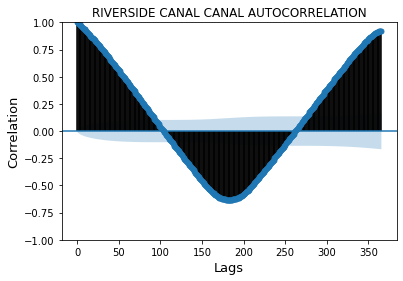

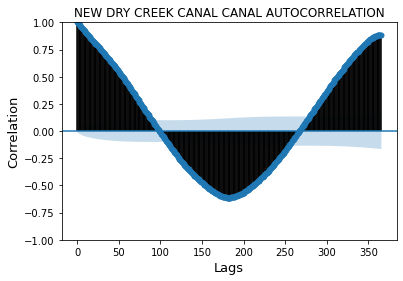

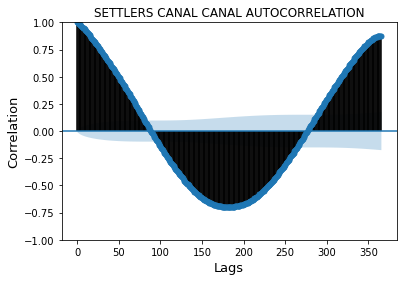

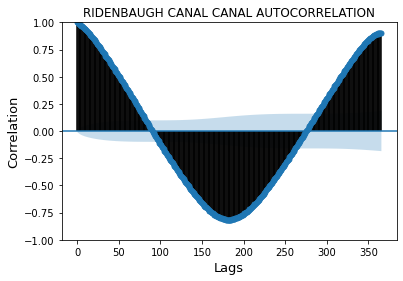

In [ ]:
## Look for autocorrelation in the seasonal component ##

#Run autocorrelation function

acf = []
for i in range(len(canals)):
  irrig = canals[i]
  acf.append(plot_acf(irrig['CFS'], title = irrig['DiversionName'][1]+' CANAL AUTOCORRELATION', lags=365))
  plt.ylabel('Correlation', size=13)
  plt.xlabel('Lags', size=13)
  plt.savefig('datasets/diversion_timeseries/figures/acf'+names[i]+'.png')



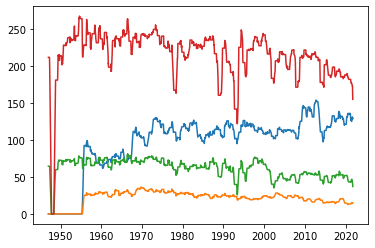

In [ ]:
## DETECT A TREND ##

sma = []

for i in range(len(canals)):
  canal = canals[i]
  sma.append((canal['CFS'].rolling(window=365).mean()))
  plt.plot(sma[i])



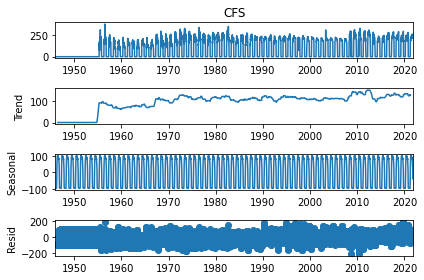

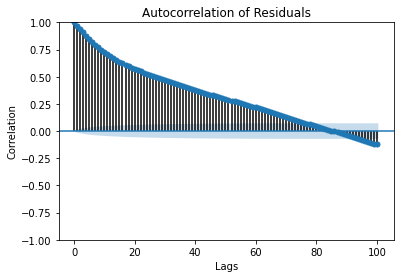

In [ ]:
## Seasonal decomposition of the data ##

rid = canals[0]
decomp = seasonal_decompose(rid['CFS'], model='additive', period=365)
decomp.plot()
plt.show()
resid = decomp.resid
nan_data = np.isnan(resid) #calls the nan values and creates a bool for nan vs number
not_nan_data = ~ nan_data #takes all the "True" values
data = resid[not_nan_data] #uses the location of the true values to create new array with no nan
plot_acf(data, title = 'Autocorrelation of Residuals', lags=100)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [ ]:
## AUTO ARIMA ## 

rid = canals[0]

rid_arima = auto_arima(rid['CFS'], start_p=1, start_q=1, max_p=3, max_q=12,
                       seasonal=True, d=0, seasonal_test='ocsb')

In [ ]:
rid_arima.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                27678
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -106728.787
Date:                Thu, 16 Dec 2021   AIC                         213469.573
Time:                        17:10:42   BIC                         213518.943
Sample:                             0   HQIC                        213485.475
                              - 27678                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0235      0.003      7.322      0.000       0.017       0.030
ar.L1          1.9874      0.003    763.856      0.000       1.982       1.993
ar.L2         -0.9877      0.003   -383.241      0.000      -0.993      -0.983
ma.L1         -0.9465      0.004   -219.821      0.000      -0.955      -0.938
ma.L2         -0.0397      0.003    -13.324      0.000      -0.046      -0.034
sigma2       131.0952      0.253    519.060      0.000     130.600     131.590
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):          30462484.73
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -1.76
Prob(H) (two-sided):                  0.00   Kurtosis:                       165.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""